In [1]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
from tsModel import NeuralNet
import networkModel
import time
import torch
import torch.nn as nn
import random

Text(0,0.5,'$X_t$')

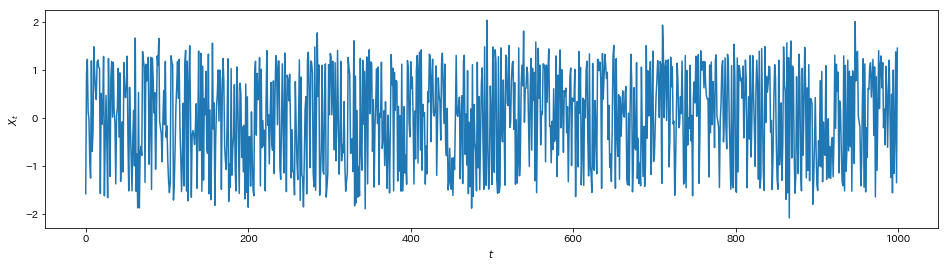

In [2]:
phi_a = [1.0, -0.5, 0.7, -0.4] ; phi_b = [0]
p = len(phi_a) ; q = len(phi_b)
dataSeed=0
N = 1000
data = NeuralNet(p=p, q=0, model_random_seed=8, random_seed=dataSeed, n_unit=[16,16,16,16], N=N, randomness="normal")
data = (data - data.mean())/data.std()
trueNet = NeuralNet(p=p, q=0, model_random_seed=8, random_seed=dataSeed, n_unit=[16,16,16,16], N=N, randomness="normal", return_net=True)
# 描画
plt.figure(figsize=(16,4))
plt.plot(data)
plt.xlabel("$t$")
plt.ylabel("$X_t$")
# plt.savefig("images/nonLinear_time-series.pdf")

In [3]:
import os
os.makedirs("parameters", exist_ok=True)
os.makedirs("parameters/experiment2/", exist_ok=True)

### 学習ハイパラメータ

In [4]:
# ネットワークのパラメータの初期値
generatorSeed = 0
discriminatorSeed = 0
predictorSeed = 0
# 学習データの食わせ方のシード
learningSeed = 0
# モデルの構造を決定するパラメータの一つ。過去に遡る時刻
hat_p = 4
hat_r = 8
# epoch回数
n_epochs = 500
# GANの学習をする回数に対する、MSEによる学習回数の割合(epoch単位)
learnRatio = 0.2
# GANのバッチ学習のサンプルサイズ
batch_size = 2
# Discriminatorのパラメータをクリップする値
clip_value=0.1
# Generatorに対してDiscriminatorが学習する回数（batch単位)
n_critic = 5
# GPの正則化係数
gp_weight = 10

### GPU or CPU

In [5]:
cuda = True if torch.cuda.is_available() else False
if cuda:
    print("GPUが使えます。")
    use_gpu = input('GPUを使いますか？ （Yes：1, No：0）  ----> ')
    cuda = bool(int(use_gpu))
else:
    print("GPUは使えません。CPUを使います。")
if cuda:
    gpu_id = input('使用するGPUの番号を入れてください　---> ')
    os.environ["CUDA_VISIBLE_DEVICES"] = gpu_id
device = torch.device('cuda:'+gpu_id if cuda else 'cpu')

GPUは使えません。CPUを使います。


### networkの定義

In [6]:
torch.manual_seed(generatorSeed)
generator = networkModel.FullConnectGenerator(input_size=hat_r+1).to(device)
torch.manual_seed(discriminatorSeed)
discriminator = networkModel.Discriminator(input_size=1).to(device)
torch.manual_seed(predictorSeed)
predictor = networkModel.Predictor(input_size=hat_p+1).to(device)

### データの整形

In [7]:
trainData = torch.tensor(data[:N*9//10], dtype=torch.float).to(device)
valData = torch.tensor(data[N*9//10:], dtype=torch.float).to(device)

In [8]:
def makeMatrix(data, width):
    data = data.view(1,-1)
    return torch.cat([data[:,i:i+width] for i in range(data.shape[1]-width+1)],dim=0)

In [9]:
class pretrainDataSet:
    def __init__(self, matrix):
        self.width = matrix.shape[1]
        self.X = matrix[:,:self.width-1] #trainMatrix # 入力
        self.Y =  matrix[:,-1] #inno[hat_r:N*9//10]# 出力

    def __len__(self):
        return len(self.X) # データ数(10)を返す

    def __getitem__(self, index):
        # index番目の入出力ペアを返す
        X = torch.cat([torch.zeros(1), self.X[index]], dim=0)
        return X, self.Y[index]

In [10]:
pretraindataset = pretrainDataSet(matrix=makeMatrix(data = trainData, width=hat_p+1))
pretraindataloader = torch.utils.data.DataLoader(pretraindataset, batch_size=batch_size, shuffle=True)

prevalX =  torch.cat([torch.zeros(len(valData)-hat_p, 1), makeMatrix(data = valData, width=hat_p+1)[:,:hat_p]], dim=1)
prevalY = makeMatrix(data = valData, width=hat_p+1)[:,-1:]

In [11]:
class DataSet:
    def __init__(self, matrix):
        self.width = matrix.shape[1]
        self.X = matrix #trainMatrix # 入力
        self.Y =  matrix[:,-1] #inno[hat_r:N*9//10]# 出力
        print(self.X.shape)

    def __len__(self):
        return len(self.X) # データ数(10)を返す

    def __getitem__(self, index):
        # index番目の入出力ペアを返す
        return self.X[index], self.Y[index]

In [12]:
traindataset = DataSet(matrix=makeMatrix(data = trainData, width=hat_r+1))
dataloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size, shuffle=True)

valX = makeMatrix(data = valData, width=hat_r+1)

torch.Size([892, 9])


In [13]:
# def makebatchMatrix(trainMatrix, b1=6, b2=64, min_margin=10, seed=None):
#     """
#     b1：いくつ連続した（X[t-p:t], X[t]）を一組みとするか
#     b2：連続の（X[t-p:t], X[t]）の組みをいくつ作るか
#     min_margin：必ずこの長さ分は間を空けてサンプルする。
#     """
#     N = trainMatrix.shape[0]+trainMatrix.shape[1]-1# 系列の長さ
#     freedom_space = N - (trainMatrix.shape[1]+b1-1 + (b2-1)*min_margin)
#     if freedom_space<=0:
#         print("データ数がたりない")
#         return None

#     np.random.seed(seed=seed)
#     # 残った自由なスペースをランダムにb2+1個に振り分ける
#     margin = np.random.multinomial(n=freedom_space, pvals=[1/(b2+1)]*(b2+1)) + min_margin
#     margin[0]-=min_margin
#     cumsum_margin = np.cumsum(margin)
#     trainMatrix = trainMatrix.view(1, trainMatrix.shape[0], trainMatrix.shape[1])
#     return torch.cat([trainMatrix[:,cumsum_margin[i]:cumsum_margin[i]+b1] for i in range(b2)])
    
# aa=makebatchMatrix(trainMatrix,b1=4, b2=32, min_margin=14, seed=None)

### 最適化

In [14]:
optimizer_G = torch.optim.RMSprop(params=generator.parameters(), lr=0.01)
optimizer_D = torch.optim.RMSprop(params=discriminator.parameters(), lr=0.01)
optimizer_F = torch.optim.Adam(params=predictor.parameters(), lr=0.001)
optimizer_pre = torch.optim.Adam(params=predictor.parameters(), lr=0.0001)

### MSE損失

In [15]:
mseLoss = nn.MSELoss().to(device)

### GP損失

In [16]:
from torch.autograd import Variable
def gradient_penalty(generated_data, real_data, gp_weight=10):
    batch_size = real_data.size()[0]

    alpha = torch.rand(batch_size, 1)
    alpha = alpha.expand_as(real_data)
    if cuda:
        alpha=alpha.to(device)

    interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
    interpolated = Variable(interpolated, requires_grad=True)
    if cuda:
        interpolated=interpolated.to(device)

    # Calculate probability of interpolated examples
    prob_interpolated = discriminator(interpolated)

    gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).to(device) if cuda else torch.ones(
                               prob_interpolated.size()),
                               create_graph=True, retain_graph=True)[0]

    gradients = gradients.view(batch_size, -1)# これいらないかも...
    
    # gradients_norm = (gradients.norm(2, dim=1) - 1) ** 2
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)# 0除算を防ぐ？

    return gp_weight * ((gradients_norm - 1) ** 2).mean()


### 事前学習

In [17]:
# グラフ描画用
loss_pre_curve = []
val_loss_pre_curve = []

# モデルパラメータの保存先
paramPath_pre = "parameters/experiment2/Predictor_pre.pth"

# epochのflossのの最小値を保管
min_floss=np.inf

# 学習データの食わせ方
torch.manual_seed(learningSeed)

# タイマー
start=time.time()

for epoch in range(1, n_epochs+1):
    
    loss_pre = 0
    for train_idx, sample in enumerate(pretraindataloader):
        X = sample[0].to(device)
        Y = sample[1].to(device).view(-1,1)
        
        train_loss = mseLoss(predictor(X), Y)        
        loss_pre += train_loss.item()
        
        train_loss.backward()# 勾配をとる
        optimizer_pre.step()
        optimizer_pre.zero_grad()
        
    loss_pre_curve.append(loss_pre/(train_idx+1))

    val_loss = mseLoss(predictor(prevalX), prevalY)
    val_loss_pre_curve.append(val_loss.item())
    
    if val_loss_pre_curve[-1]<min_floss:
        min_floss = val_loss_pre_curve[-1]
        torch.save(predictor.state_dict(), paramPath_pre)
        print(f"epoch：{epoch}/{n_epochs}  val_loss_F:{val_loss_pre_curve[-1]: .4g}   経過時間：{time.time()-start: .1f}秒　　saved")
        
    
    if epoch % 10 == 0 and min_floss != val_loss_pre_curve[-1]:
        print(f"epoch：{epoch}/{n_epochs}  val_loss_F:{val_loss_pre_curve[-1]: .4g}   経過時間：{time.time()-start: .1f}秒")
    


epoch：1/500  val_loss_F: 0.9838   経過時間： 1.6秒　　saved
epoch：2/500  val_loss_F: 0.9802   経過時間： 3.0秒　　saved
epoch：3/500  val_loss_F: 0.9797   経過時間： 4.3秒　　saved
epoch：10/500  val_loss_F: 0.9802   経過時間： 13.1秒
epoch：20/500  val_loss_F: 0.98   経過時間： 25.3秒
epoch：24/500  val_loss_F: 0.9791   経過時間： 29.3秒　　saved
epoch：26/500  val_loss_F: 0.9787   経過時間： 31.2秒　　saved
epoch：27/500  val_loss_F: 0.9787   経過時間： 32.2秒　　saved
epoch：28/500  val_loss_F: 0.9778   経過時間： 33.5秒　　saved
epoch：29/500  val_loss_F: 0.9769   経過時間： 35.2秒　　saved
epoch：30/500  val_loss_F: 0.9769   経過時間： 36.4秒　　saved
epoch：31/500  val_loss_F: 0.9764   経過時間： 37.8秒　　saved
epoch：33/500  val_loss_F: 0.9763   経過時間： 40.7秒　　saved
epoch：34/500  val_loss_F: 0.9754   経過時間： 42.8秒　　saved
epoch：38/500  val_loss_F: 0.9751   経過時間： 47.0秒　　saved
epoch：40/500  val_loss_F: 0.975   経過時間： 48.9秒　　saved
epoch：41/500  val_loss_F: 0.9746   経過時間： 49.9秒　　saved
epoch：42/500  val_loss_F: 0.9738   経過時間： 50.8秒　　saved
epoch：43/500  val_loss_F: 0.9734   経過時間： 51.7秒　　sav

KeyboardInterrupt: 

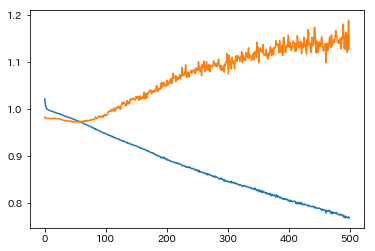

In [18]:
plt.plot(loss_pre_curve)
plt.plot(val_loss_pre_curve)

In [18]:
predictor.load_state_dict(torch.load(paramPath_pre)) 

<All keys matched successfully>

In [19]:
# 次時刻の時系列値を各時刻ごとに予測しながら予測時系列を作成する（再帰的な予測ではない）
def predict_next(data, predictor):
    predict = np.empty_like(data)
    for i in range(len(data)):
        if i<hat_p:
            predict[i] = np.nan
        else:
            input_tensor = torch.cat([torch.zeros(1,1),torch.tensor(data[i-hat_p:i]).view(1,-1)], dim=1)
            predict[i] = predictor(input_tensor).item()
    return predict

(0, 100)

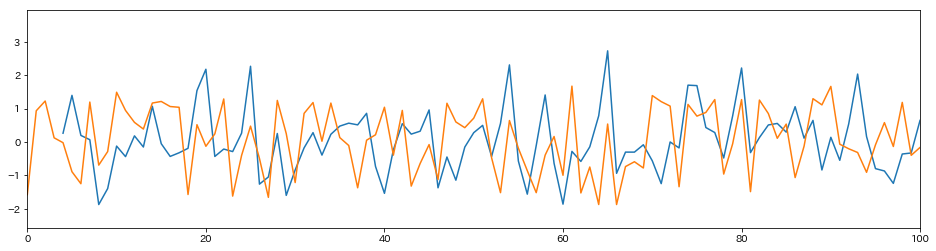

In [20]:
predict = predict_next(data=data, predictor=predictor)
predict = (predict-predict[hat_p:].mean())/predict[hat_p:].std()
plt.figure(figsize=(16,4))
plt.plot(predict)
plt.plot(data)
plt.xlim(0,100)

In [21]:
((predict[hat_p:]-data[hat_p:])**2).mean()

1.65645

### 学習

In [22]:
# グラフ描画用
loss_D_curve = []
loss_G_curve = []
loss_F_curve = []
val_loss_D_curve = []
val_loss_G_curve = []
val_loss_F_curve = []

# モデルパラメータの保存先
paramPath_G = "parameters/experiment2/FullConnectGenerator.pth"
paramPath_D = "parameters/experiment2/Discriminator.pth"
paramPath_F = "parameters/experiment2/Predictor.pth"

# epochのflossのの最小値を保管
min_floss=np.inf

# 学習データの食わせ方
torch.manual_seed(learningSeed)
random.seed(a=learningSeed)

# batch計算回数の保管
batch_done_mse = 0
batch_done_ganD = 0
batch_done_ganG = 0

# タイマー
start=time.time()

for epoch in range(1, n_epochs+1):
    
    if epoch % 20 == 0 or epoch == 1:
        """
        MSEの学習
        """
        loss_F = 0
        for train_idx, sample in enumerate(dataloader):
            train_G_input = sample[0]
            train_G_output = generator(train_G_input)
            train_F_input = torch.cat([train_G_output, sample[0][:,-hat_p-1:-1]], dim=1)
            train_F_output = predictor(train_F_input)
            
            mse_loss = mseLoss(train_F_output, sample[1])
            mse_loss.backward()# 勾配をとる
            optimizer_G.step()# 勾配情報と最適化手法を元にparameterを更新
            optimizer_F.step()
            optimizer_G.zero_grad()
            optimizer_F.zero_grad()

            loss_F += mse_loss.item()
            batch_done_mse += 1
            
        loss_F_curve.append(loss_F/(train_idx+1))
    else:
        loss_F_curve.append(loss_F_curve[-1])
#     break 

    """
    GANの学習
    """
    loss_G = []
    loss_D = 0
#     l=list(range(trainMatrix.shape[0]-batch_size))
#     batch_sample = random.sample(l, len(l))
#     for i, batch in enumerate(batch_sample):
    for train_idx, sample in enumerate(dataloader):
        train_G_input = sample[0]
        """
        Discriminatorの学習
        """
        # discriminatorの勾配の更新をONにする
        for param in discriminator.parameters():
            param.requires_grad = True
        
        # discriminatorのパラメタをクリップする（全てのパラメタの絶対値がclip_value以下の値になる）
#         for param in discriminator.parameters():
#             param.data.clamp_(-clip_value, clip_value)
        
        train_G_output = generator(train_G_input)
        eps= torch.randn_like(train_G_output)
        
        gan_lossD = -torch.mean(discriminator(eps)) + torch.mean(discriminator(train_G_output))
        gan_lossD.backward(retain_graph=True)# 勾配をとる
        optimizer_D.step()
        optimizer_D.zero_grad()
        optimizer_G.zero_grad() # Generatorの勾配情報も更新されてしまっているので。
        
        if batch_done_ganD % (100 if batch_done_ganG<25 or batch_done_ganG%500==0 else n_critic) == 0:
#         if True:
            """
            Generatorの学習
            """
            # discriminatorの勾配の更新をOFFにする
            for param in discriminator.parameters():
                param.requires_grad = False
            
            gan_lossG = -torch.mean(discriminator(train_G_output))
            gan_lossG += gradient_penalty(generated_data=train_G_output, real_data=eps, gp_weight=gp_weight) 
            gan_lossG.backward()
            optimizer_G.step()
            optimizer_G.zero_grad()
            
            batch_done_ganG += 1
        
            loss_G.append(gan_lossG.item())
        loss_D += gan_lossD.item()
        batch_done_ganD += 1
    loss_G_curve.append((sum(loss_G)/len(loss_G) if not loss_G==[] else 0))
    loss_D_curve.append(loss_D/(train_idx+1))
        
    """
    validationの計算
    """
    val_G_input = valX
    val_G_output = generator(val_G_input)
    val_F_input = torch.cat([val_G_output, valX[:,-hat_p-1:-1]], dim=1)
    val_F_output = predictor(val_F_input)
    eps = torch.randn_like(val_G_output)
    val_loss_D_curve.append((-torch.mean(discriminator(eps)) + torch.mean(discriminator(val_G_output))).item())
    val_loss_G_curve.append(-torch.mean(discriminator(val_G_output)).item())
    val_loss_F_curve.append(mseLoss(val_F_output, valX[:,-1:]).item())
    
#     break
    # val_loss_Dの値が一番小さいモデルを保存する
    if val_loss_F_curve[-1]<min_floss:
        min_floss = val_loss_F_curve[-1]
        torch.save(generator.state_dict(), paramPath_G)
        torch.save(discriminator.state_dict(), paramPath_D)
        torch.save(predictor.state_dict(), paramPath_F)
        print(f"epoch：{epoch}/{n_epochs}   val_loss_D：{val_loss_D_curve[-1]: .4g}  val_loss_G:{val_loss_G_curve[-1]: .4g}   val_loss_F:{val_loss_F_curve[-1]: .4g}   経過時間：{time.time()-start: .1f}秒　　saved")
        
    
    if epoch % 10 == 0 and min_floss != val_loss_F_curve[-1]:
        print(f"epoch：{epoch}/{n_epochs}   val_loss_D：{val_loss_D_curve[-1]: .4g}  val_loss_G:{val_loss_G_curve[-1]: .4g}   val_loss_F:{val_loss_F_curve[-1]: .4g}   経過時間：{time.time()-start: .1f}秒")
    
#     break

/Users/ryuichi/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch：1/500   val_loss_D：-9.183e+05  val_loss_G:-2.635e+05   val_loss_F: 0.9806   経過時間： 2.9秒　　saved
epoch：2/500   val_loss_D：-1.365e+07  val_loss_G: 1.596e+07   val_loss_F: 0.6689   経過時間： 4.3秒　　saved
epoch：10/500   val_loss_D： 2.219e+06  val_loss_G:-9.014e+06   val_loss_F: 0.9802   経過時間： 12.5秒
epoch：20/500   val_loss_D： 2.122e+06  val_loss_G:-1.338e+07   val_loss_F: 0.9434   経過時間： 26.4秒
epoch：30/500   val_loss_D：-2.241e+05  val_loss_G:-4.077e+06   val_loss_F: 0.9734   経過時間： 39.9秒
epoch：40/500   val_loss_D： 2.158e+06  val_loss_G:-1.59e+07   val_loss_F: 0.9924   経過時間： 53.3秒
epoch：50/500   val_loss_D：-1.104e+05  val_loss_G:-1.09e+07   val_loss_F: 0.9742   経過時間： 66.5秒
epoch：60/500   val_loss_D：-8.184e+06  val_loss_G:-2.498e+07   val_loss_F: 0.9696   経過時間： 82.3秒
epoch：70/500   val_loss_D：-1.961e+06  val_loss_G:-1.185e+07   val_loss_F: 0.9565   経過時間： 94.8秒
epoch：80/500   val_loss_D： 6.527e+06  val_loss_G:-1.684e+07   val_loss_F: 0.9966   経過時間： 110.0秒
epoch：90/500   val_loss_D： 1.001e+05  val

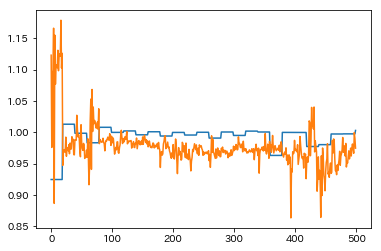

In [26]:
plt.plot(loss_F_curve)
plt.plot(val_loss_F_curve)

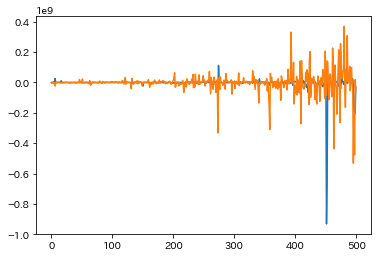

In [27]:
plt.plot(loss_D_curve)
plt.plot(val_loss_D_curve)

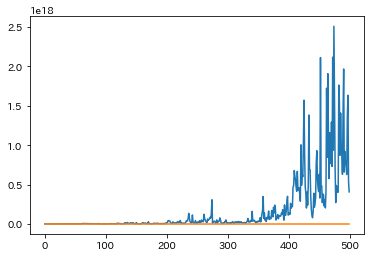

In [28]:
plt.plot(loss_G_curve)
plt.plot(val_loss_G_curve)

## =======================================================================

In [30]:
generator.load_state_dict(torch.load(paramPath_G))

<All keys matched successfully>

In [ ]:
discriminator.state_dict()

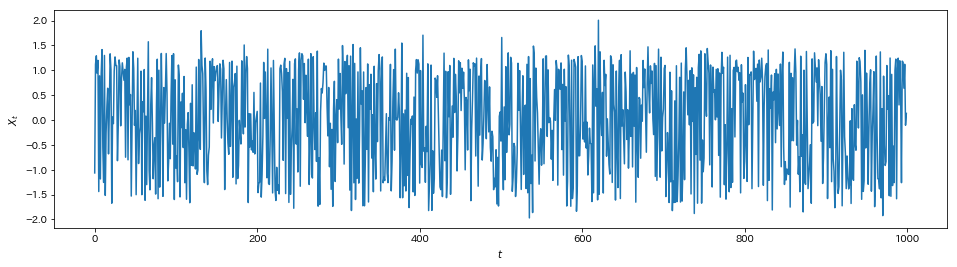

In [51]:
testdata = NeuralNet(p=p, q=0, model_random_seed=8, random_seed=2**32-1, n_unit=[16,16,16,16], N=N, randomness="normal")
testdata = (testdata - testdata.mean())/testdata.std()
# 描画
plt.figure(figsize=(16,4))
plt.plot(testdata)
plt.xlabel("$t$")
plt.ylabel("$X_t$")
# plt.savefig("images/test.pdf")

Text(0.5, 0, '$t$')

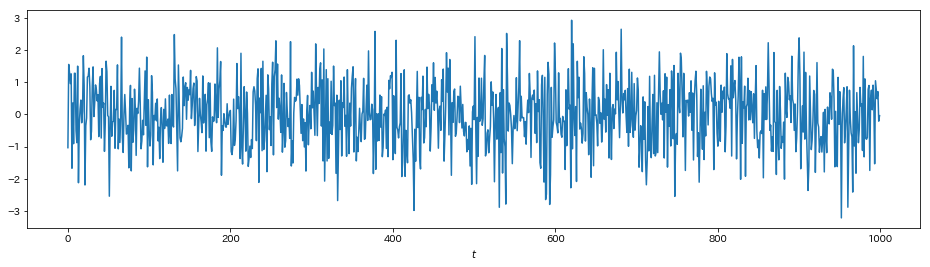

In [32]:
testinno = np.array(NeuralNet(p=p, q=0, model_random_seed=8, random_seed=2**32-1, n_unit=[16,16,16,16], N=N, randomness="normal", return_innovation=True))
plt.figure(figsize=(16,4))
plt.plot(testinno)
plt.xlabel("$t$")


In [33]:
def predict_inno(data, generator):
    predict = np.empty_like(data)
    for i in range(len(data)):
        if i<hat_r:
            predict[i] = np.nan
        else:
            input_tensor = torch.tensor(data[i-hat_r:i+1]).view(1,-1)
            predict[i] = generator(input_tensor).item()
    return predict

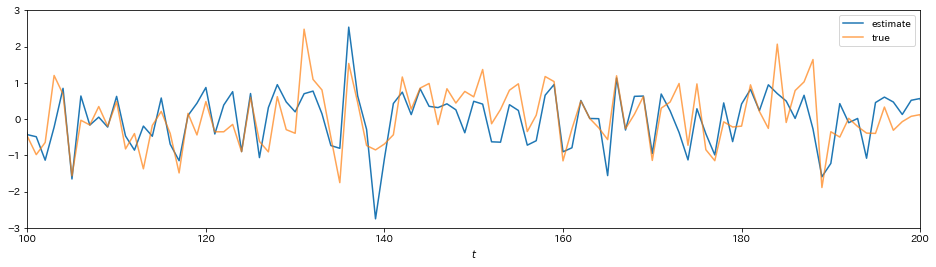

In [54]:
predict = predict_inno(data=testdata, generator=generator)
predict = (predict - predict[hat_r:].mean())/predict[hat_r:].std()
plt.figure(figsize=(16,4))
plt.plot(predict, label="estimate")
plt.plot(testinno, label="true", alpha=0.7)
plt.xlabel("$t$")
# plt.ylabel("$\hat\\varepsilon_t$")
plt.legend()

plt.ylim(-3,3)
# plt.savefig("../images/estimated_innovation3.pdf")
plt.savefig("images/result.pdf")
plt.xlim(100,200)
plt.savefig("images/result_detail.pdf")

In [44]:
print(((predict[hat_r:]-testinno[hat_r:])**2).mean())

0.7693749
